In [1]:
# Archived scripts that may be of interest

import sqlite3
import numpy as np
import scipy.stats as st
%pylab inline

class GeomMean:
    def __init__(self):
        self.values = []
    def step(self, value):
        self.values += [value]
    def finalize(self):
        return st.gmean(self.values)
    

conn = sqlite3.connect('../results.db')
conn.create_aggregate("GeomMean", 1, GeomMean)

c = conn.cursor() 


readable = { "NUMBERJACK":"Toulbar2", "GECODE":"Gecode", "OR_TOOLS":"OR-Tools", "CHOCO":"Choco",
            "JACOP":"JaCoP", "G12":"G12", "GECODE_NAT" : "Native Gecode"}

readableProblems = { "on-call-rostering":"On-call Rostering", "mspsp":"MSPSP", "soft-queens":"Soft N-Queens",
                    "talent-scheduling":"Talent Scheduling", "photo":"Photo Placement"}
from collections import defaultdict

problemToInstance = defaultdict(list)
c.execute("SELECT Problem, Count(Distinct Instance) as Instances FROM JobResult Group By Problem")
for row in c.fetchall():
    problemToInstance[row[0]] = row[1]

    
c.execute("SELECT COUNT(*) FROM ( SELECT Distinct Instance FROM JobResult )")
res = c.fetchone()
numberProblems = res[0]

print "We tried", numberProblems, "instances."


Populating the interactive namespace from numpy and matplotlib
We tried 28 instances.


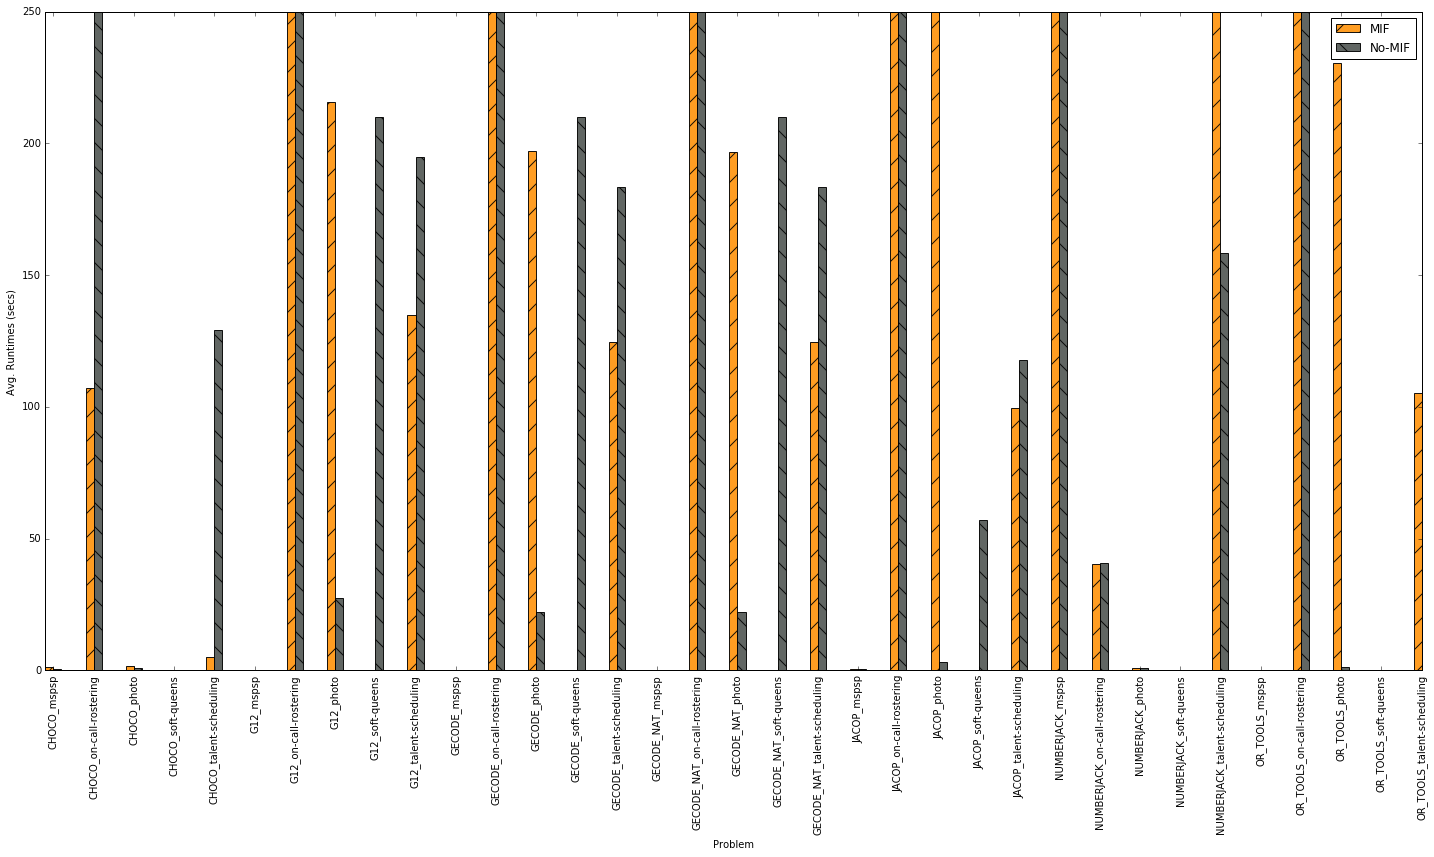

In [4]:
scriptFile = open("query-mif-comp-solver-problem.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

mifElapseds = defaultdict(list)
mifStds = defaultdict(list)
normalElapseds = defaultdict(list)
normalStds = defaultdict(list)

solversProblems = []


for row in c.fetchall():
    (solver, problem, mifElapsed, mifVar, normalElapsed, normalVar) = row
    solverProblem = solver+"_"+problem
    solversProblems += [solverProblem]
    mifElapseds[solverProblem] = mifElapsed
    mifStds[solverProblem] = np.sqrt(mifVar)
    normalElapseds[solverProblem] = normalElapsed
    normalStds[solverProblem] = np.sqrt(normalVar)
    #mifWinss[problem] = mifWins
    #instances[problem] = overall
    #ratios[problem] = ratio
    #print row


import numpy as np
isseorange = (1.0, 0.57647, 0.039216)
#\definecolor{issegrey}{RGB}{80,85,82}
issegrey = (80.0 / 255, 85.0 / 255, 82.0 / 255)

n_groups = len(solversProblems)

means_mif = [mifElapseds[p] for p in solversProblems]
std_mif = [mifStds[p] for p in solversProblems]


means_nomif =  [normalElapseds[p] for p in solversProblems]
std_nomif = [normalStds[p] for p in solversProblems]

fig, ax = plt.subplots(figsize=(20,12))

index = np.arange(n_groups)
bar_width = 0.2


opacity = 0.9
error_config = {'ecolor': '0.3'}
plt.ylim([0,250])
plt.xlim([0,5])
rects1 = plt.bar(index, means_mif, bar_width,
                 alpha=opacity,
                 color=isseorange,
                 error_kw=error_config,
                 hatch="/",
                 label='MIF')

rects2 = plt.bar(index + bar_width, means_nomif, bar_width,
                 alpha=opacity,
                 color=issegrey,
                 hatch="\\",
                 error_kw=error_config,
                 label='No-MIF')

plt.xlabel('Problem')
plt.ylabel('Avg. Runtimes (secs)')
#plt.title('Runtimes by problem and heuristic')
plt.xticks(index + bar_width , solversProblems,  rotation='vertical')
plt.legend()

plt.tight_layout()

plt.savefig('runtime-mif-problem-solver.pdf', bbox_inches='tight')
plt.show()


In [3]:
### Now we analyze whether the geometric mean provides useful insight
import scipy.stats as st

scriptFile = open("query-mif-geom.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

mifElapseds = []
mifToNormals = []
normalElapseds = []
normalToMifs = []

for row in c.fetchall():
    (mifElapsed, mifToNormal, normalElapsed, normalToMif) = row
    mifElapseds += [mifElapsed]
    mifToNormals += [mifToNormal]
    normalElapseds += [normalElapsed]
    normalToMifs += [normalToMif]
    
# now let's get the geometric mean of mif to normal
mifToNormal = np.array(mifToNormals)
print st.gmean(mifToNormals)

# and the geometric mean of normal to mif
normalToMif = np.array(normalToMifs)
print st.gmean(normalToMifs)


0.910246472856
1.09860354291


Note how we can calculate the geometric mean for a series $x_1, \ldots, x_n$:

$$(\prod_i x_i)^{1/n} = \exp(\log((\prod_i x_i)^\frac{1}{n})) = 
\exp ( \frac{1}{n} \log(\prod_i x_i)) = \exp(\frac{1}{n} \sum_i \log(x_i)) $$

In [4]:

scriptFile = open("query-mif-geom-agg.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)
print c.fetchone()


(0.9102464728556013, 1.0986035429094565)
